In [2]:
import torch
import math
from simple_fem import FEM, import_mesh, Quad
import matplotlib.pyplot as plt
from math import sqrt
import meshio as meshio
import numpy as np

torch.set_default_dtype(torch.double)


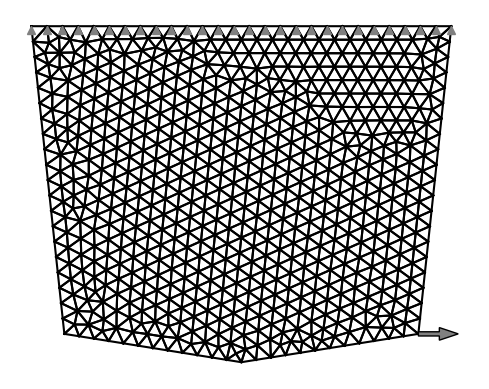

In [15]:
# Import mesh
hood = import_mesh("golfy.vtu", 1000.0, 0.33)

# top = hood.nodes[0, 1] == 0

# bottom = hood.nodes[:, 1] == 0.0
# hood.forces[bottom, 0] = 1.0
# hood.forces[3, 0] = 1.0
hood.forces[0, 0] = 1.0

# print(max(hood.nodes[:, 1]))
top = hood.nodes[:, 1] == 200
hood.constraints[top, 1] = True

# hood.forces[0, 0] = 1.0

# Material properties
nu = 0.33
E = 1000.0

# Thickness
d = 0.1
thickness = d * torch.ones(len(hood.elements))

# Plot the fillet
Tria = FEM(hood.nodes, hood.elements, hood.forces, hood.constraints, thickness=thickness, E=E, nu=nu)
Tria.plot()

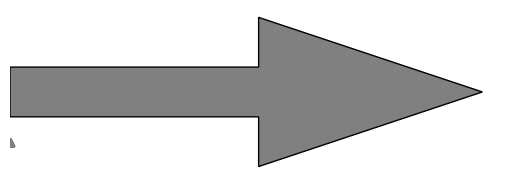

In [16]:
# Solve
u, f = Tria.solve()

# Plot
Tria.plot(u, node_property=torch.norm(u, dim=1))

In [9]:
def bisection(f, a, b, max_iter=50, tol=1e-12):
    # Bisection method always finds a root, even with highly non-linear grad
    i = 0
    while (b - a) > tol:
        c = (a + b) / 2.0
        if i > max_iter:
            raise Exception(f"Bisection did not converge in {max_iter} iterations.")
        if f(a) * f(c) > 0:
            a = c
        else:
            b = c
        i += 1
    return c

In [10]:
def optimize(fem, rho_0, rho_min, rho_max, V_0, iter=1, xi=0.5, m=0.2, p=1.0, r=0.0):
    rho = [rho_0]
    vols = d * fem.areas()

    # Check if there is a feasible solution before starting iteration
    if torch.inner(rho_min, vols) > V_0:
        raise Exception("rho_min is not compatible with V_0.")

    # Precompute filter weights
    if r > 0.0:
        H = r - fem.dist
        H[fem.dist > r] = 0.0

    # Iterate solutions
    for k in range(iter):
        # Adjust thickness variables
        fem.thickness = d * rho[k] ** p

        # Compute solution
        u_k, f_k = fem.solve()

        # Compute sensitivities
        w_k = fem.element_strain_energies(u_k)
        sensitivity = -p * d * rho[k] ** (p - 1) * 2.0 * w_k

        # Filter sensitivities (if r provided)
        if r > 0.0:
            sensitivity = H @ (rho[k] * sensitivity) / H.sum(dim=0) / rho[k]

        # For a certain value of mu, apply the iteration scheme
        def make_step(mu):
            G_k = -sensitivity / (mu * vols)
            upper = torch.min(rho_max, (1 + m) * rho[k])
            lower = torch.max(rho_min, (1 - m) * rho[k])
            rho_trial = G_k**xi * rho[k]
            return torch.maximum(torch.minimum(rho_trial, upper), lower)

        # Constraint function
        def g(mu):
            rho_k = make_step(mu)
            return torch.dot(rho_k, vols) - V_0

        # Find the root of g(mu)
        mu = bisection(g, 1e-10, 100.0)

        # Evaluation
        compliance = torch.inner(f_k.ravel(), u_k.ravel())
        print(f"Iteration k={k} - Compliance: {compliance:.5f}")

        rho.append(make_step(mu))

    return rho

In [11]:
# Initial thickness, minimum thickness, maximum thickness
rho_0 = 0.5 * torch.ones(len(hood.elements))
rho_min = 0.01 * torch.ones_like(rho_0)
rho_max = 1.0 * torch.ones_like(rho_0)

# Initial volume (40% of maximum design volume)
vols = d * hood.areas()
V0 = 0.4 * vols.sum()

Iteration k=0 - Compliance: 3121156803840.25586
Iteration k=1 - Compliance: nan
Iteration k=2 - Compliance: nan
Iteration k=3 - Compliance: nan
Iteration k=4 - Compliance: nan
Iteration k=5 - Compliance: nan
Iteration k=6 - Compliance: nan
Iteration k=7 - Compliance: nan
Iteration k=8 - Compliance: nan
Iteration k=9 - Compliance: nan
Iteration k=10 - Compliance: nan
Iteration k=11 - Compliance: nan
Iteration k=12 - Compliance: nan
Iteration k=13 - Compliance: nan
Iteration k=14 - Compliance: nan
Iteration k=15 - Compliance: nan
Iteration k=16 - Compliance: nan
Iteration k=17 - Compliance: nan
Iteration k=18 - Compliance: nan
Iteration k=19 - Compliance: nan
Iteration k=20 - Compliance: nan
Iteration k=21 - Compliance: nan
Iteration k=22 - Compliance: nan
Iteration k=23 - Compliance: nan
Iteration k=24 - Compliance: nan
Iteration k=25 - Compliance: nan
Iteration k=26 - Compliance: nan
Iteration k=27 - Compliance: nan
Iteration k=28 - Compliance: nan
Iteration k=29 - Compliance: nan
Iter

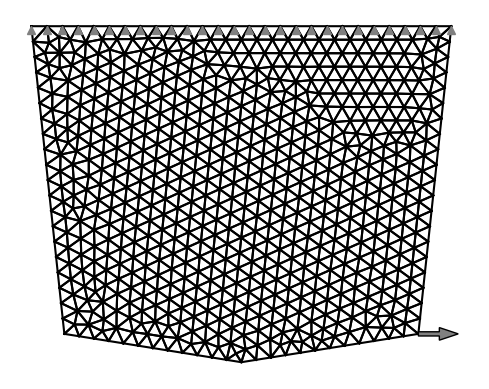

In [12]:
# Optimize and visualize results
d_opt = optimize(hood, rho_0, rho_min, rho_max, V0, iter=50, p=3.0, r=0.0)
hood.plot(element_property=d_opt[-1])